# Extracting Text from Images in Python

<img src="https://media.arxiv-vanity.com/render-output/6158804/images/fig_2_no_trademarks.png" alt="text to images" width="600" height="600">


In [1]:
import pandas as pd
import numpy as np

from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from PIL import Image

plt.style.use('ggplot')

In [ ]:
#SequentialMatcher sample code: https://www.appsloveworld.com/pandas/100/327/comparing-strings-within-two-columns-in-pandas-with-sequencematcher

# Outline
1. Take a look at the data
2. Extract text from images:
    - pytesseract
    - easyocr
    - keras_ocr
3. Run on a few examples and compare the results

In [2]:
# annot = pd.read_parquet('../input/textocr-text-extraction-from-images-dataset/annot.parquet')
# imgs = pd.read_parquet('../input/textocr-text-extraction-from-images-dataset/img.parquet')
# img_fns = glob('../input/textocr-text-extraction-from-images-dataset/train_val_images/train_images/*')

annot = pd.read_parquet('input/annot.parquet')
imgs = pd.read_parquet('input/img.parquet')
img_fns = glob('input/train_val_images/train_images/*')

# Plot Example Images

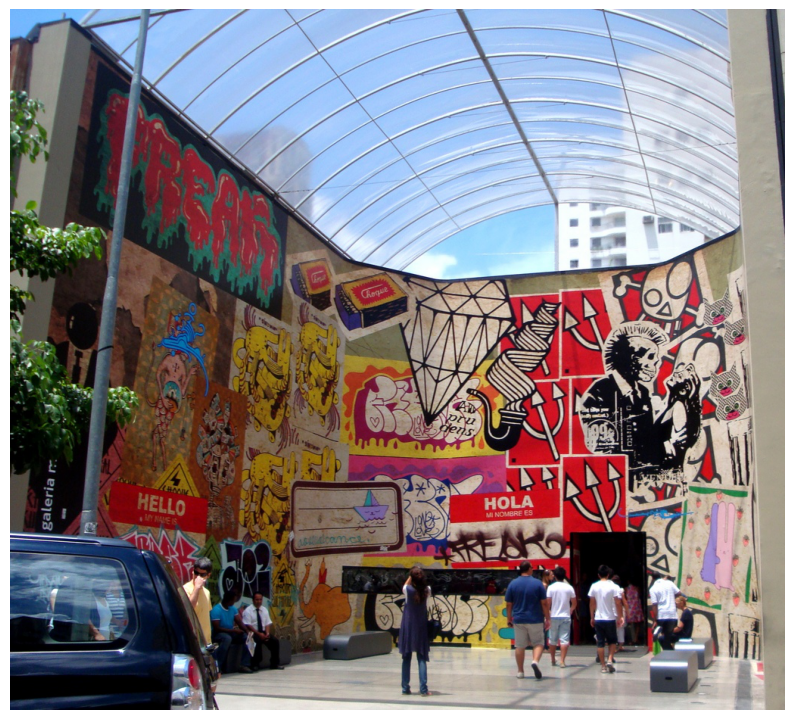

In [3]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(plt.imread(img_fns[12]))
ax.axis('off')
plt.show()

In [10]:
# image_id = img_fns[0].split('/')[-1].split('.')[0]
image_id = img_fns[0].split('/')[-1].split('.')[0].split('\\')[1]
annot.query('image_id == @image_id')

,id,image_id,bbox,utf8_string,points,area


In [11]:
image_id

'0000599864fd15b3'

In [4]:
annot.head(10)

,id,image_id,bbox,utf8_string,points,area
0,a4ea732cd3d5948a_1,a4ea732cd3d5948a,"[525.83, 3.4, 197.64, 33.94]",Performance,"[525.83, 3.4, 723.47, 7.29, 722.76, 36.99, 525...",6707.90
1,a4ea732cd3d5948a_2,a4ea732cd3d5948a,"[534.67, 64.68, 91.22, 38.19]",Sport,"[535.73, 64.68, 623.41, 67.51, 625.89, 102.87,...",3483.69
2,a4ea732cd3d5948a_3,a4ea732cd3d5948a,"[626.95, 63.62, 96.52, 31.82]",Watch,"[626.95, 63.62, 721.7, 63.62, 723.47, 95.44, 6...",3071.27
3,a4ea732cd3d5948a_4,a4ea732cd3d5948a,"[577.4, 141.87, 147.13, 43.1]",...period.,"[580.02, 143.61, 724.53, 141.87, 723.66, 184.9...",6341.30
4,a4ea732cd3d5948a_5,a4ea732cd3d5948a,"[391.03, 163.9, 60.82, 38.65]",.,"[395.2, 163.9, 451.85, 191.94, 445.59, 202.55,...",2350.69
5,a4ea732cd3d5948a_6,a4ea732cd3d5948a,"[455.64, 204.45, 21.97, 24.82]",400,"[464.54, 204.45, 477.61, 221.88, 469.85, 229.2...",545.30
6,a4ea732cd3d5948a_7,a4ea732cd3d5948a,"[474.58, 234.95, 17.24, 24.25]",300,"[484.43, 234.95, 491.82, 253.9, 482.35, 259.2,...",418.07
7,a4ea732cd3d5948a_8,a4ea732cd3d5948a,"[506.48, 263.69, 25.42, 41.99]",15,"[531.9, 263.69, 531.43, 304.04, 507.18, 305.68...",1067.39
8,a4ea732cd3d5948a_9,a4ea732cd3d5948a,"[346.4, 177.05, 54.56, 38.48]",12,"[346.4, 180.79, 397.52, 177.05, 400.96, 215.53...",2099.47
9,a4ea732cd3d5948a_10,a4ea732cd3d5948a,"[364.49, 163.27, 19.82, 16.08]",60,"[364.49, 163.27, 383.73, 163.27, 384.31, 178.7...",318.71


# Method 1: pytesseract

In [12]:
import pytesseract

# Example call
print(pytesseract.image_to_string(img_fns[12], lang='eng'))

TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.

In [ ]:
len(img_fns)

In [ ]:
####Loop through each image to extract text and save in df. Meanwhile calculate run time
import pytesseract
from pytesseract import Output
from tqdm import tqdm, trange
from difflib import SequenceMatcher

# record start time 
import timeit
start_time = timeit.default_timer()


#create an empty dataframe
df=pd.DataFrame(columns = ['image_id', 'text'])

#loop through each image and append results
for i in trange(len(img_fns)):
    image_id = img_fns[i].split('/')[-1].rstrip('.jpg')
    data=pytesseract.image_to_data(img_fns[i],output_type=Output.DATAFRAME )
    data['image_id']=image_id
    df=df.append(data[['image_id','text']],ignore_index=True)

# caculate the run time in sec
elapsed = timeit.default_timer() - start_time

#remove NaN and missing values from df
df1=df[df.text!=' '].dropna()

#concatenate text field by groupby image_id
df2=df1.sort_values('text').groupby(['image_id'], as_index=False).agg({'text': ' '.join})

annot_agg=annot[['image_id','utf8_string']].sort_values('utf8_string').groupby(['image_id'], as_index=False).agg({'utf8_string': ' '.join})

final_p=annot_agg.merge(df2, how='left', left_on='image_id',right_on='image_id')

def apply_sm(df):
    if not df[['utf8_string', 'text']].isnull().any():
        return SequenceMatcher(None, df['utf8_string'], df['text']).ratio()
    return 0.0
final_p['ratio']=final_p.apply(apply_sm,axis=1)
final_p["ratio"].mean()

In [ ]:
elapsed/3600

# Method 2: easyocr

In [ ]:
####Loop through each image to extract text and save in df. Meanwhile calculate run time
import easyocr
reader = easyocr.Reader(['en'], gpu = True)

# record start time 
import timeit
start_time = timeit.default_timer()


#create an empty dataframe
df=pd.DataFrame(columns = ['image_id', 'text'])

#loop through each image and append results
for i in trange(len(img_fns)):
    image_id = img_fns[i].split('/')[-1].rstrip('.jpg')
    results = reader.readtext(img_fns[i])
    data=pd.DataFrame(results, columns=['bbox','text','conf'])
    data['image_id']=image_id
    df=df.append(data[['image_id','text']],ignore_index=True)

# caculate the run time in sec
elapsed = timeit.default_timer() - start_time


#remove NaN and missing values from df
df1=df[df.text!=' '].dropna()

#concatenate text field by groupby image_id
df2=df1.sort_values('text').groupby(['image_id'], as_index=False).agg({'text': ' '.join})

annot_agg=annot[['image_id','utf8_string']].sort_values('utf8_string').groupby(['image_id'], as_index=False).agg({'utf8_string': ' '.join})

final_p=annot_agg.merge(df2, how='left', left_on='image_id',right_on='image_id')

def apply_sm(df):
    if not df[['utf8_string', 'text']].isnull().any():
        return SequenceMatcher(None, df['utf8_string'], df['text']).ratio()
    return 0.0
final_p['ratio']=final_p.apply(apply_sm,axis=1)
final_p["ratio"].mean()



In [ ]:
elapsed/3600

# Method 3: keras_ocr

In [ ]:
# !pip install keras-ocr -q

In [ ]:
import keras_ocr

pipeline = keras_ocr.pipeline.Pipeline()

In [ ]:
results = pipeline.recognize([img_fns[11]])

In [ ]:
pd.DataFrame(results[0], columns=['text', 'bbox'])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
keras_ocr.tools.drawAnnotations(plt.imread(img_fns[11]), results[0], ax=ax)
ax.set_title('Keras OCR Result Example')
plt.show()

# Compare easyocr vs. keras_ocr

In [ ]:
# easyocr
reader = easyocr.Reader(['en'], gpu = True)

dfs = []
for img in tqdm(img_fns[:25]):
    result = reader.readtext(img)
    img_id = img.split('/')[-1].split('.')[0]
    img_df = pd.DataFrame(result, columns=['bbox','text','conf'])
    img_df['img_id'] = img_id
    dfs.append(img_df)
easyocr_df = pd.concat(dfs)

In [ ]:
# keras_ocr
pipeline = keras_ocr.pipeline.Pipeline()

dfs = []
for img in tqdm(img_fns[:25]):
    results = pipeline.recognize([img])
    result = results[0]
    img_id = img.split('/')[-1].split('.')[0]
    img_df = pd.DataFrame(result, columns=['text', 'bbox'])
    img_df['img_id'] = img_id
    dfs.append(img_df)
kerasocr_df = pd.concat(dfs)

# Plot Results: easyocr vs keras_ocr

In [ ]:
def plot_compare(img_fn, easyocr_df, kerasocr_df):
    img_id = img_fn.split('/')[-1].split('.')[0]
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))

    easy_results = easyocr_df.query('img_id == @img_id')[['text','bbox']].values.tolist()
    easy_results = [(x[0], np.array(x[1])) for x in easy_results]
    keras_ocr.tools.drawAnnotations(plt.imread(img_fn), 
                                    easy_results, ax=axs[0])
    axs[0].set_title('easyocr results', fontsize=24)

    keras_results = kerasocr_df.query('img_id == @img_id')[['text','bbox']].values.tolist()
    keras_results = [(x[0], np.array(x[1])) for x in keras_results]
    keras_ocr.tools.drawAnnotations(plt.imread(img_fn), 
                                    keras_results, ax=axs[1])
    axs[1].set_title('keras_ocr results', fontsize=24)
    plt.show()

In [ ]:
# Loop over results
for img_fn in img_fns[:25]:
    plot_compare(img_fn, easyocr_df, kerasocr_df)

# The End